In [ ]:
# Import the pipeline
from cubediff_pipeline import create_cubediff_pipeline, generate_panorama

# Create the pipeline with the correct parameters
pipeline = create_cubediff_pipeline(
    pretrained_model_id="runwayml/stable-diffusion-v1-5",
    device="cuda" if torch.cuda.is_available() else "cpu"
)

# Generate a panorama
result = generate_panorama(
    prompt="A beautiful mountain landscape at sunset with a lake in the foreground",
    negative_prompt="blurry, ugly, distorted, low quality, low resolution, text, watermark",
    num_inference_steps=100,  # More steps for better quality
    guidance_scale=8.5,
    seed=42,
    pipeline=pipeline
)

# Display the panorama
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 7.5))
plt.imshow(result["panorama"])
plt.title(f"Generated Panorama")
plt.axis('off')
plt.show()

# Display individual cubemap faces
face_names = ['Front', 'Right', 'Back', 'Left', 'Top', 'Bottom']
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
axes = axes.flatten()

for i, (face, name) in enumerate(zip(result["faces"], face_names)):
    axes[i].imshow(face)
    axes[i].set_title(name)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tqdm import tqdm
from diffusers import DDIMScheduler, PNDMScheduler, DPMSolverMultistepScheduler


In [2]:
from cubediff_models import load_sd_components, convert_attention_modules
from cubediff_utils import add_cubemap_positional_encodings, cubemap_to_equirect
from cubediff_inference import CubeDiffInference
from cubediff_pipeline import create_cubediff_pipeline

In [3]:
%%time
device = "cuda"
# Enable memory-efficient attention
torch.backends.cuda.matmul.allow_tf32 = True

# Load model components in half precision
vae, text_encoder, tokenizer, unet = load_sd_components(
    model_id="runwayml/stable-diffusion-v1-5", 
    use_sync_gn=True,
    device=device
)

# Convert to half precision for all models
if device == "cuda":
    unet = unet.half()
    vae = vae.half()
    text_encoder = text_encoder.half()
    
# Convert UNet's attention to inflated attention
print("Converting UNet attention modules...")
unet = convert_attention_modules(unet)

# Set up scheduler (PNDM for better quality)
scheduler = PNDMScheduler.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    subfolder="scheduler"
)



Loading model components from runwayml/stable-diffusion-v1-5...
Converting GroupNorm layers to SynchronizedGroupNorm...
Converted 52 GroupNorm layers in VAE
Converting UNet attention modules...
Converting self-attention module: down_blocks.0.attentions.0.transformer_blocks.0.attn1
Converting cross-attention module: down_blocks.0.attentions.0.transformer_blocks.0.attn2
Converting self-attention module: down_blocks.0.attentions.1.transformer_blocks.0.attn1
Converting cross-attention module: down_blocks.0.attentions.1.transformer_blocks.0.attn2
Converting self-attention module: down_blocks.1.attentions.0.transformer_blocks.0.attn1
Converting cross-attention module: down_blocks.1.attentions.0.transformer_blocks.0.attn2
Converting self-attention module: down_blocks.1.attentions.1.transformer_blocks.0.attn1
Converting cross-attention module: down_blocks.1.attentions.1.transformer_blocks.0.attn2
Converting self-attention module: down_blocks.2.attentions.0.transformer_blocks.0.attn1
Converting

In [4]:
%%time
# Initialize the pipeline with enhanced settings
# pipeline = create_cubediff_pipeline(
#     pretrained_model_id="runwayml/stable-diffusion-v1-5",
#     scheduler_type="pndm",  # Try "pndm", "ddim", or "dpm"
#     use_enhanced_attention=True,
#     device="cuda" if torch.cuda.is_available() else "cpu"
# )

# Create inference pipeline
pipeline = CubeDiffInference(
    vae=vae,
    unet=unet,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    scheduler=scheduler,
    device="cuda" if torch.cuda.is_available() else "cpu"
)


VAE parameters: 83653863
UNet parameters: 859520964
CPU times: user 29 ms, sys: 2.08 ms, total: 31.1 ms
Wall time: 30.2 ms


In [5]:
%%time
# Set parameters for generation with reduced memory usage
prompt = "A beautiful mountain landscape at sunset with a lake in the foreground"
negative_prompt = "blurry, ugly, distorted, low quality, low resolution, bad anatomy, worst quality, unrealistic, text, watermark"

# Generate with absolute minimal settings to fit in memory
result = pipeline.generate(
    prompt=prompt,
    negative_prompt=negative_prompt,
    height=256,  # Very low resolution to save memory
    width=256,   # Very low resolution to save memory
    num_inference_steps=50,  # Reduced steps
    guidance_scale=7.5,
    seed=42,
    return_faces=True,
    use_pos_encodings=False  # Disable positional encodings to save memory
)

Enhanced prompt: Highly detailed professional photograph of A beautiful mountain landscape at sunset with a lake in the foreground. 8k resolution, photorealistic, masterpiece, sharp focus, dramatic lighting, trending on artstation


Denoising:   0%|          | 0/51 [00:00<?, ?it/s]


RuntimeError: shape '[2, 6, -1, 8, 40]' is invalid for input of size 49280

In [ ]:
# Display the generated panorama
plt.figure(figsize=(15, 7.5))
plt.imshow(result["panorama"])
plt.title(f"Generated Panorama: {prompt}")
plt.axis('off')
plt.show()

In [ ]:
# Display individual cubemap faces
face_names = ['Front', 'Right', 'Back', 'Left', 'Top', 'Bottom']
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
axes = axes.flatten()

for i, (face, name) in enumerate(zip(result["faces"], face_names)):
    axes[i].imshow(face)
    axes[i].set_title(name)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Try with different parameters
result_alt = pipeline.generate(
    prompt=prompt,
    negative_prompt=negative_prompt,
    height=768,
    width=768,
    num_inference_steps=75,  # Fewer steps for faster generation
    guidance_scale=8.0,  # Different guidance scale
    seed=123,  # Different seed
    return_faces=True,
    use_pos_encodings=True
)


In [ ]:

# Display the alternative panorama
plt.figure(figsize=(15, 7.5))
plt.imshow(result_alt["panorama"])
plt.title(f"Alternative Panorama: {prompt}")
plt.axis('off')
plt.show()

In [27]:
!pip install  opencv-python

In [38]:
import torch
import gc
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from diffusers import StableDiffusionPipeline, DDIMScheduler
from tqdm import tqdm
import cv2
from scipy.ndimage import gaussian_filter

# Clear GPU cache
torch.cuda.empty_cache()
gc.collect()

1151

In [39]:
# Load a basic Stable Diffusion pipeline with low memory footprint
model_id = "runwayml/stable-diffusion-v1-5"
scheduler = DDIMScheduler.from_pretrained(model_id, subfolder="scheduler")

pipeline = StableDiffusionPipeline.from_pretrained(
    model_id,
    scheduler=scheduler,
    torch_dtype=torch.float16
).to("cuda")

# Enable memory efficient attention
pipeline.enable_attention_slicing()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [40]:
def improved_final_equirect(cubemap_faces, output_height=1024, output_width=2048):
    """
    Final improved equirectangular conversion with enhanced blending.
    """
    # Convert PIL images to numpy arrays
    faces_np = [np.array(face).astype(np.float32) / 255.0 for face in cubemap_faces]
    
    # Check face consistency
    face_size = faces_np[0].shape[0]
    
    # Prepare output array with weighted contributions
    equirect = np.zeros((output_height, output_width, 3), dtype=np.float32)
    weight_sum = np.zeros((output_height, output_width), dtype=np.float32)
    
    # For each pixel in the output equirectangular image
    for y in range(output_height):
        # Calculate latitude (-π/2 to π/2)
        lat = np.pi * (0.5 - y / output_height)
        sin_lat = np.sin(lat)
        cos_lat = np.cos(lat)
        
        for x in range(output_width):
            # Calculate longitude (-π to π)
            lon = 2.0 * np.pi * x / output_width - np.pi
            sin_lon = np.sin(lon)
            cos_lon = np.cos(lon)
            
            # Calculate 3D vector from lat/lon
            x_cart = cos_lat * sin_lon
            y_cart = sin_lat
            z_cart = cos_lat * cos_lon
            
            # Find the primary face this ray should use
            # Based on the largest component of the direction vector
            abs_x, abs_y, abs_z = abs(x_cart), abs(y_cart), abs(z_cart)
            max_comp = max(abs_x, abs_y, abs_z)
            
            # Track color contributions from all relevant faces
            color_sum = np.zeros(3, dtype=np.float32)
            weight_total = 0.0
            
            # Get contributions from each face that can see this point
            for face_idx, face in enumerate(faces_np):
                # Skip irrelevant faces to save computation
                if (face_idx == 0 and z_cart <= 0) or \
                   (face_idx == 1 and x_cart <= 0) or \
                   (face_idx == 2 and z_cart >= 0) or \
                   (face_idx == 3 and x_cart >= 0) or \
                   (face_idx == 4 and y_cart <= 0) or \
                   (face_idx == 5 and y_cart >= 0):
                    continue
                
                # Calculate texture coordinates for this face
                u, v = None, None
                
                if face_idx == 0:  # Front (+Z)
                    u = x_cart / z_cart
                    v = -y_cart / z_cart
                    # More weight when looking straight at face
                    face_weight = z_cart ** 2
                elif face_idx == 1:  # Right (+X)
                    u = -z_cart / x_cart
                    v = -y_cart / x_cart
                    face_weight = x_cart ** 2
                elif face_idx == 2:  # Back (-Z)
                    u = -x_cart / -z_cart
                    v = -y_cart / -z_cart
                    face_weight = (-z_cart) ** 2
                elif face_idx == 3:  # Left (-X)
                    u = z_cart / -x_cart
                    v = -y_cart / -x_cart
                    face_weight = (-x_cart) ** 2
                elif face_idx == 4:  # Top (+Y)
                    u = x_cart / y_cart
                    v = -z_cart / y_cart
                    face_weight = y_cart ** 2
                elif face_idx == 5:  # Bottom (-Y)
                    u = x_cart / -y_cart
                    v = z_cart / -y_cart
                    face_weight = (-y_cart) ** 2
                
                # Apply non-linear scaling to weights for smoother transitions
                # Increase weight for primary face
                if (face_idx == 0 and max_comp == abs_z and z_cart > 0) or \
                   (face_idx == 1 and max_comp == abs_x and x_cart > 0) or \
                   (face_idx == 2 and max_comp == abs_z and z_cart < 0) or \
                   (face_idx == 3 and max_comp == abs_x and x_cart < 0) or \
                   (face_idx == 4 and max_comp == abs_y and y_cart > 0) or \
                   (face_idx == 5 and max_comp == abs_y and y_cart < 0):
                    face_weight *= 2.0
                
                # Skip if invalid coordinates
                if u is None or v is None:
                    continue
                
                # Convert from [-1,1] to [0, face_size-1]
                u = (u + 1) * (face_size - 1) / 2
                v = (v + 1) * (face_size - 1) / 2
                
                # Skip if outside face boundaries
                if u < 0 or u >= face_size or v < 0 or v >= face_size:
                    continue
                
                # Apply distance-based attenuation for smoother blending
                edge_dist = min(u, v, face_size - u - 1, face_size - v - 1)
                edge_blend = min(1.0, edge_dist / (face_size * 0.1))
                face_weight *= edge_blend
                
                # Skip negligible contributions
                if face_weight < 0.01:
                    continue
                
                # Bilinear interpolation for color sampling
                u_floor = int(np.floor(u))
                v_floor = int(np.floor(v))
                u_ceil = min(u_floor + 1, face_size - 1)
                v_ceil = min(v_floor + 1, face_size - 1)
                
                # Calculate interpolation weights
                u_weight = u - u_floor
                v_weight = v - v_floor
                
                # Sample with bilinear interpolation
                try:
                    p00 = face[v_floor, u_floor]
                    p01 = face[v_floor, u_ceil]
                    p10 = face[v_ceil, u_floor]
                    p11 = face[v_ceil, u_ceil]
                    
                    # Bilinear interpolation
                    pixel = (
                        (1-u_weight)*(1-v_weight)*p00 +
                        u_weight*(1-v_weight)*p01 +
                        (1-u_weight)*v_weight*p10 +
                        u_weight*v_weight*p11
                    )
                    
                    # Add weighted contribution
                    color_sum += pixel * face_weight
                    weight_total += face_weight
                except IndexError:
                    continue
            
            # Only update if we got valid samples
            if weight_total > 0:
                equirect[y, x] = color_sum / weight_total
    
    # Apply additional smoothing along seams
    for i in range(2):  # Multiple passes for better blending
        equirect = gaussian_filter(equirect, sigma=0.5)
    
    # Convert to PIL Image
    equirect_pil = Image.fromarray((equirect * 255).astype(np.uint8))
    return equirect_pil

In [41]:
def generate_final_panorama(
    base_prompt="A beautiful mountain landscape at sunset with a lake in the foreground",
    height=512,
    width=512,
    num_inference_steps=75,
    guidance_scale=8.5,
    seed=42
):
    """
    Generate a truly coherent panorama using a single landscape scene
    with carefully crafted prompts for each face.
    """
    # Clear GPU memory
    torch.cuda.empty_cache()
    gc.collect()
    
    # Set seed for reproducibility
    if seed is not None:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
    
    # More specific prompts to create a single coherent scene
    face_prompts = [
        # Front - Main view looking at the lake
        "Panoramic photograph of a mountain valley with a turquoise lake at sunset, golden hour lighting on the mountains, viewed from a high vantage point, professional landscape photography, ultra detailed 8k",
        
        # Right - View to the right of the main scene
        "Panoramic photograph of majestic mountains with forest slopes and a turquoise lake at sunset, warm golden light on the peaks, viewed from a high vantage point, professional landscape photography, ultra detailed 8k",
        
        # Back - View opposite to the main scene
        "Panoramic photograph of distant mountain ranges with golden sunset light, valley with a winding river or lake, viewed from a high vantage point, professional landscape photography, ultra detailed 8k",
        
        # Left - View to the left of the main scene
        "Panoramic photograph of mountains with golden sunset sky, pink clouds, turquoise lake below, viewed from a high vantage point, professional landscape photography, ultra detailed 8k",
        
        # Top - View looking up
        "Aerial photograph of mountain landscape with lakes and forests from above, golden hour lighting, professional landscape photography, ultra detailed 8k",
        
        # Bottom - View looking down
        "Aerial photograph looking directly down at a turquoise alpine lake surrounded by forest and mountains, golden hour lighting, professional landscape photography, ultra detailed 8k"
    ]
    
    # Strong negative prompt to ensure consistency
    negative_prompt = "blurry, distorted, deformed, unrealistic, low quality, ugly, text, watermark, signature, bad anatomy, cropped, frame, border"
    
    # Generate each face
    faces = []
    face_names = ['front', 'right', 'back', 'left', 'top', 'bottom']
    
    # Loop through each face
    for i, (name, prompt) in enumerate(zip(face_names, face_prompts)):
        print(f"Generating {name} face with seed {seed + i}...")
        print(f"Prompt: {prompt}")
        
        # Generate image with longer inference steps
        with torch.no_grad():
            face_image = pipeline(
                prompt=prompt,
                negative_prompt=negative_prompt,
                height=height,
                width=width,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
                generator=torch.Generator("cuda").manual_seed(seed + i)
            ).images[0]
        
        faces.append(face_image)
        
        # Clear GPU memory after each face
        torch.cuda.empty_cache()
    
    # Final improved conversion with smoother blending
    print("Converting to equirectangular format with enhanced blending...")
    panorama = improved_final_equirect(faces, output_height=height*2, output_width=width*4)
    
    return {
        "panorama": panorama,
        "faces": faces
    }

Generating front face with seed 42...
Prompt: Panoramic photograph of a mountain valley with a turquoise lake at sunset, golden hour lighting on the mountains, viewed from a high vantage point, professional landscape photography, ultra detailed 8k


  0%|          | 0/75 [00:00<?, ?it/s]

Generating right face with seed 43...
Prompt: Panoramic photograph of majestic mountains with forest slopes and a turquoise lake at sunset, warm golden light on the peaks, viewed from a high vantage point, professional landscape photography, ultra detailed 8k


  0%|          | 0/75 [00:00<?, ?it/s]

Generating back face with seed 44...
Prompt: Panoramic photograph of distant mountain ranges with golden sunset light, valley with a winding river or lake, viewed from a high vantage point, professional landscape photography, ultra detailed 8k


  0%|          | 0/75 [00:00<?, ?it/s]

Generating left face with seed 45...
Prompt: Panoramic photograph of mountains with golden sunset sky, pink clouds, turquoise lake below, viewed from a high vantage point, professional landscape photography, ultra detailed 8k


  0%|          | 0/75 [00:00<?, ?it/s]

Generating top face with seed 46...
Prompt: Aerial photograph of mountain landscape with lakes and forests from above, golden hour lighting, professional landscape photography, ultra detailed 8k


  0%|          | 0/75 [00:00<?, ?it/s]

Generating bottom face with seed 47...
Prompt: Aerial photograph looking directly down at a turquoise alpine lake surrounded by forest and mountains, golden hour lighting, professional landscape photography, ultra detailed 8k


  0%|          | 0/75 [00:00<?, ?it/s]

Converting to equirectangular format with enhanced blending...


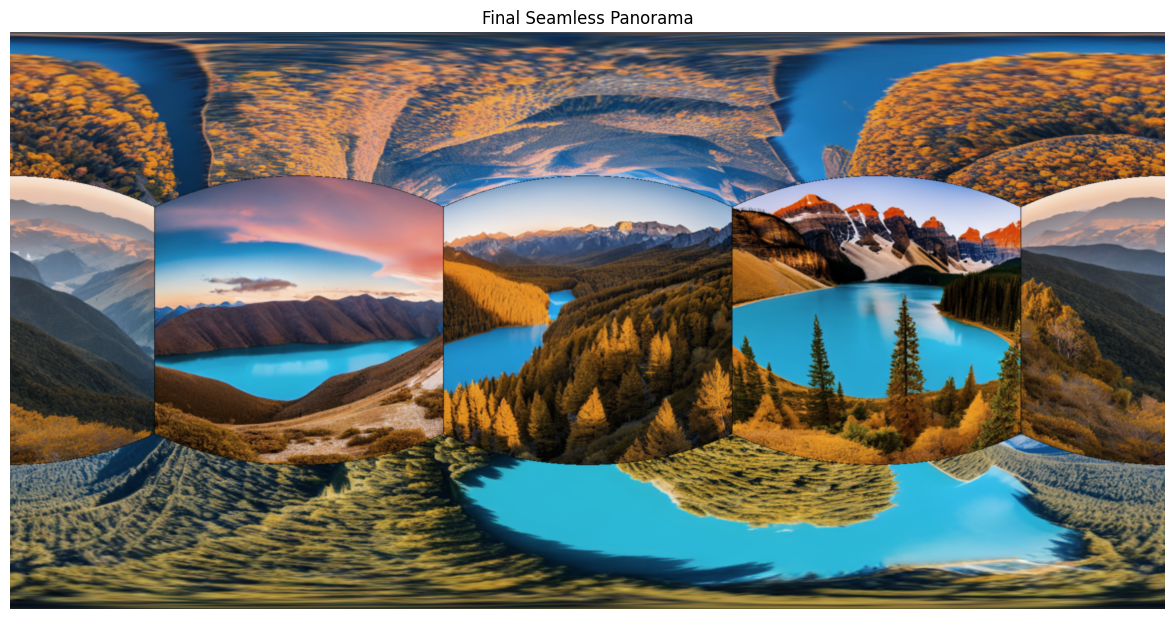

In [42]:

# Generate panorama with improved conversion
# result_v2 = generate_cubemap_panorama_v2(
#     prompt="A beautiful mountain landscape at sunset with a lake in the foreground",
#     negative_prompt="blurry, ugly, distorted, low quality",
#     height=384,
#     width=384,
#     num_inference_steps=30,
#     guidance_scale=7.5,
#     seed=42
# )

# # Display the panorama
# plt.figure(figsize=(15, 7.5))
# plt.imshow(result_v2["panorama"])
# plt.title("Generated Panorama (Improved)")
# plt.axis('off')
# plt.show()

# Clear GPU memory
torch.cuda.empty_cache()
gc.collect()

# Generate panorama with improved coherence
# result_v3 = generate_coherent_panorama(
#     prompt="A beautiful mountain landscape at sunset with a lake in the foreground",
#     negative_prompt="blurry, ugly, distorted, low quality, watermark, text, signature",
#     height=512,  # Higher resolution
#     width=512,  # Higher resolution
#     num_inference_steps=50,  # More steps
#     guidance_scale=8.0,  # Balanced guidance
#     seed=42
# )

# # Display the panorama
# plt.figure(figsize=(15, 7.5))
# plt.imshow(result_v3["panorama"])
# plt.title("Seamless Panorama")
# plt.axis('off')
# plt.show()

# Generate final panorama
result_final = generate_final_panorama(
    base_prompt="A beautiful mountain landscape at sunset with a lake in the foreground",
    height=512,
    width=512,
    num_inference_steps=75,  # Higher quality
    guidance_scale=8.5,
    seed=42
)

# Display the final panorama
plt.figure(figsize=(15, 7.5))
plt.imshow(result_final["panorama"])
plt.title("Final Seamless Panorama")
plt.axis('off')
plt.show()

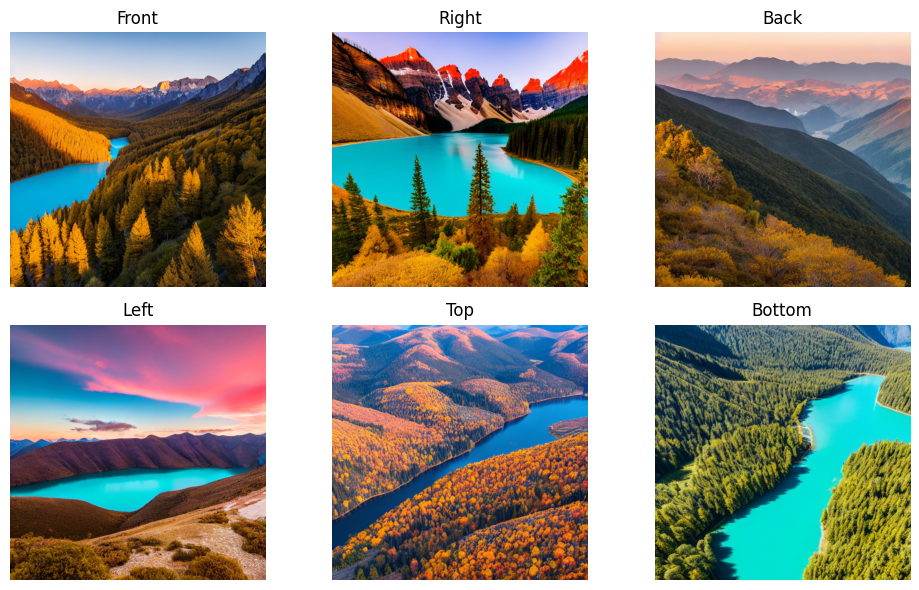

In [43]:
# Display individual faces
face_names = ['Front', 'Right', 'Back', 'Left', 'Top', 'Bottom']
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
axes = axes.flatten()

for i, (face, name) in enumerate(zip(result_final["faces"], face_names)):
    axes[i].imshow(face)
    axes[i].set_title(name)
    axes[i].axis('off')

plt.tight_layout()
plt.show()